# Experimental run on the Atlanta dataset

In [1]:
from pathlib import Path
import json
import random

import numpy as np
import torch
import pandas as pd
import geopandas as gpd
import igraph as ig

import matplotlib.pyplot as plt
import seaborn as sns

from eptnr.rewards.egalitarian import EgalitarianTheilReward
from eptnr.plotting.data_exploration import plot_travel_time_histogram, get_melted_tt_df

/home/rico/anaconda3/envs/tbr-eptnr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Problem Setup

In [2]:
graph: ig.Graph = ig.read(Path('../atlanta_data/resulting_graph/Atlanta_problem_graph_2023-05-17.gml'))
census = gpd.read_parquet(Path('../atlanta_data/atlanta_census.parquet'))

In [20]:
# Set that all groups that should be considered and the edge types that can be removed
groups = None
edge_types = {'METRO'}

In [21]:
# Remove all PTN edges that are not of type edge_types
# graph = graph.subgraph_edges(graph.es.select(type_in=edge_types.union({'walk'})))

In [22]:
reward = EgalitarianTheilReward(census_data=census, groups=groups, verbose=False)

In [23]:
def set_seeds(seed: int = 2048):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [24]:
# Get total number of metro edges
nr_total_edges = len(graph.es.select(type_in=edge_types))
# Reduce by certain amount of percent
budget = int(0.05 * nr_total_edges)
print(f"Budget is {budget}/{nr_total_edges} of graph edges of type{'s' if len(edge_types) > 1 else ''} {', '.join(edge_types)}")

Budget is 2/46 of graph edges of type METRO


## Pre-Departure Analysis

In [25]:
def get_tt_stats(g: ig.Graph, census_df: pd.DataFrame):
    melted_tt_df = get_melted_tt_df(g, census_df)
    return melted_tt_df.groupby('group')['travel time'].agg(['mean', 'median', 'var']).reset_index()

In [26]:
get_tt_stats(graph, census)

,group,mean,median,var
0,nw,39.102674,35.586134,134.307556
1,w,40.973376,38.070168,146.544783


<AxesSubplot: xlabel='travel time', ylabel='Count'>

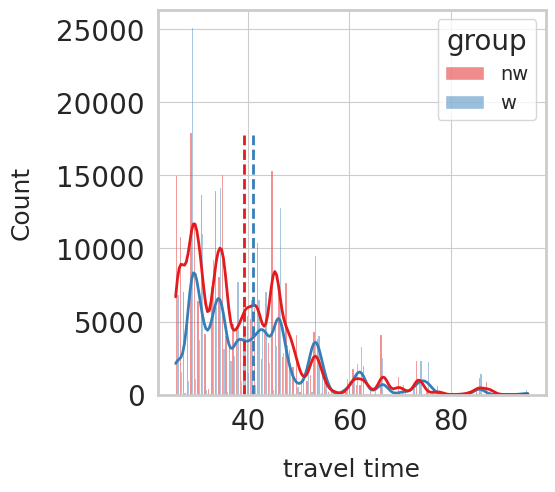

In [27]:
plot_travel_time_histogram(graph, census)

# Complete search

In [29]:
from eptnr.algorithms.baselines import full_exploration_baseline

results_file = Path('./full_results.json')

if not results_file.exists():
    results = full_exploration_baseline(g=graph, reward=reward, edge_types=edge_types, budget=budget)
    json.dump(results, open(results_file,'w'))
else:
    results = json.load(open(results_file,'r'))

100%|██████████| 1035/1035 [36:27<00:00,  2.11s/it]


In [45]:
df = pd.DataFrame.from_dict(results, orient='index', columns=['value'])
df = df.reset_index(drop=False)
df['candidates'] = df['index']
del df['index']
df = df.sort_values('value',ascending=False)
df = df.reset_index(drop=True)

In [60]:
df

,value,candidates
0,-0.036187,"[5, 6]"
1,-0.037064,"[15, 23]"
2,-0.037093,"[15, 20]"
3,-0.037098,"[15, 25]"
4,-0.037191,"[15, 38]"
...,...,...
1076,-0.047778,"[7, 16]"
1077,-0.047988,"[7, 29]"
1078,-0.049659,"[7, 17]"
1079,-0.054221,"[16, 17]"


## Full search, optimal baseline run

In [32]:
from eptnr.algorithms.baselines import optimal_max_baseline

set_seeds()

opt_edges = [(-0.03618716902188749, [5, 6])]

if opt_edges is None:
    opt_edges = optimal_max_baseline(g=graph, reward=reward, edge_types=edge_types, budget=budget, verbose=False)
opt_edges

[(-0.03618716902188749, [5, 6])]

In [35]:
opt_reduced_graph = graph.copy()
opt_reduced_graph.delete_edges(opt_edges[0][1])

In [36]:
get_tt_stats(opt_reduced_graph, census)

,group,mean,median,var
0,nw,40.650255,37.334538,132.483698
1,w,41.902407,39.464958,135.654156


<AxesSubplot: xlabel='travel time', ylabel='Count'>

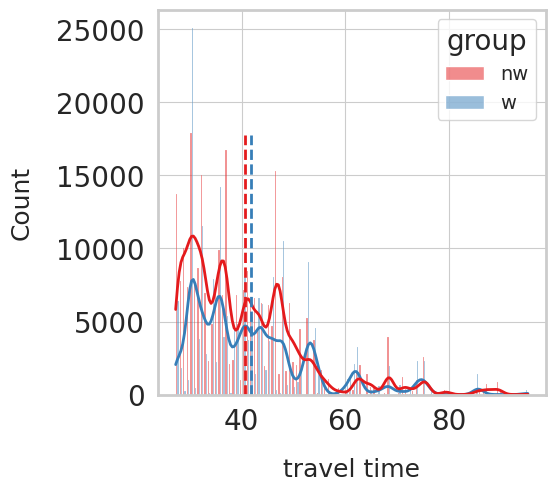

In [37]:
plot_travel_time_histogram(opt_reduced_graph, census)